# Example: the EMRI mass function.

In this notebook, we validate a 1-dimensional population Fisher-matrix for the spectral index of the EMRI mass function against numerical MCMC results.

The model is the same used in the [tutorial here](https://github.com/aantonelli94/PopFisher/blob/main/GW_like_examples/tutorial_EMRI_mass_function_no_selectioneffects.ipynb). As a result, the code will not be as heavily commented.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import matplotlib as mpl
import seaborn as sns
import time


from scipy.special import erfc
from sympy.parsing import mathematica as M


from MCMC_PowerLaw   import * # Import utils to perform the MCMC analysis.
from Fisher_PowerLaw import * # Import utils to calculate the Fisher estimates.


%matplotlib inline
np.random.seed(1234)


params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

### Generate data

The data are generated in the same way as the tutorial, with a spectral index that is flat in the log of the masses and lower and upper limits $10^4 M_\odot < M < 10^7 M_\odot$.

In [2]:
"""
Parameters
"""

N_obs = 100
N_samps_likelihoods = 10
N_samps_selfunction = 5000 # Needs to be high to sample well the selection function's integral.
                            # but small enough to avoid slowing the Fisher calculation too much.


alpha0_t = 0.00001 # Choose flat spectral profile.
M_min=10000. ;   logM_min = np.log(M_min) # M runs from 10^4
M_max=10000000.; logM_max = np.log(M_max) # to 10^7 solar masses.

The analytical inversion of the power-law to get samples for the masses has been coded up in the $\texttt{log_M()}$ function. See the [tutorial](https://github.com/aantonelli94/PopFisher/blob/main/GW_like_examples/tutorial_EMRI_mass_function_no_selectioneffects.ipynb) for more details as to how this is done.


In [3]:
"""
Noise characteristics.
"""

sigma = 1.
dth = 13.0
noise = np.random.normal(0,sigma,size = N_obs)

"""
Data draws.
"""

u = np.random.uniform(size=N_obs)
logM_t=log_M(alpha0_t, N_obs, M_max,M_min)
d_i = noise + logM_t  # observations made of noise + true population.
d_i_selbias = d_i[d_i>dth]
N_det = len(d_i_selbias)

print('Out of', N_obs,'possible events,', N_det,'are detected.')

"""
Data array. The structure of data is such that Data[i,j] is the jth posterior sample from event i.
We assume the observation model p(d|theta) is a normal gaussian with noise variance sigma.

"""

logM_obs_selbias=np.zeros((N_det,N_samps_likelihoods))
for i in np.arange(N_det):
    logM_obs_selbias[i,:]=np.random.normal(d_i_selbias[i],sigma,size=N_samps_likelihoods)
data = logM_obs_selbias


Out of 100 possible events, 47 are detected.


Plot the true and observed populations. If a threshold lower than the lower limit of integration in the masses has been chosen, the two populations will be clearly distinguishable.

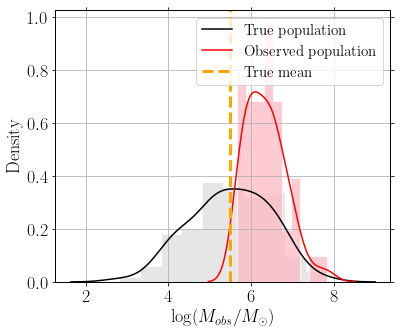

In [4]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(np.log10(np.exp(d_i)),density=True,bins=10,histtype = 'stepfilled',
                               color ='gainsboro', alpha=0.7, edgecolor='white')
sns.kdeplot(np.array(np.log10(np.exp(d_i))), label='True population',c='k')
plt.hist(np.log10(np.exp(d_i_selbias)),density=True,bins=10,histtype = 'stepfilled',
                            color ='lightpink', alpha=0.7, edgecolor='white')
sns.kdeplot(np.array(np.log10(np.exp(d_i_selbias))), label='Observed population',c='red')
    
plt.axvline(x=np.log10(np.exp(np.mean(logM_t))), label='True mean', c='orange',ls='--',lw=3)

plt.xlabel('$\log(M_{obs}/M_\odot)$')
plt.ylabel('Density')
plt.legend()

### Fitting

We fit the population likelihood here assuming flat gaussian priors on $\alpha$. Notice that the relevant function for the log_likelihood-- "log_likelihood()" -- is found in MCMC_PowerLaw.py. The argument it requires are fed into the args option in the "EnsembleSampler".

Notice that the "log_likelihood()" function takes into account selection effects. These are obtained solving the following integral with Monte Carlo methods,

  $$p_\text{det}(\lambda) = \int p_\text{det}(\theta) p(\theta|\lambda) d\theta \approx \frac{1}{N_\text{samp}}\sum \frac{p_\text{det}(\theta_{ij})}{2}\text{erfc}\left[\frac{d_\text{th}-\theta_{ij}}{\sqrt{2}\sigma}\right]\quad (\text{with } \theta_{ij}\sim p(\theta|\lambda)).$$

This integration is performed in the "selection_function" function called by "log_likelihood()".

In [5]:
# Limits of (flat) hyperpriors.

hyperprior_min = -10.0
hyperprior_max = 10.0

# Iterations, ndims and walkers.

n_iter = 10000
ndim = 1; nwalkers = 2

# Initialization of the MCMC. Perturb away from true values.

pos_init0 = [alpha0_t]
p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

# Sampling

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=[data,hyperprior_min,hyperprior_max,
                                      N_samps_selfunction, M_max, M_min, sigma, dth, N_det])
run = sampler.run_mcmc(p0, n_iter, progress=True)

100%|████████████████████████████████████| 10000/10000 [00:16<00:00, 618.19it/s]


Prepare samples and check the trace.

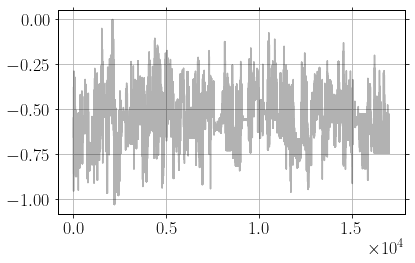

In [6]:
"""
Collect the samples here.
"""
burnin = 1500

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
alpha_samples = chains[:,:,0].flatten()

plt.plot(alpha_samples, "k", alpha=0.3)
plt.tight_layout()
plt.show()

### Fisher estimates

This expressions has been coded up for a mono-parametric (but generic) power-law model in the function "FM_1D_powerlaw" function below, which is found in Fisher_PowerLaw.py.

Details as to how this is calculated and implemented are reported in [this note](https://github.com/aantonelli94/PopFisher/blob/main/GW_like_examples/code_for_paper_results/Notes_1D_FM_PowerLaw.ipynb).

In [7]:
#samples drawn from PDF to be used in the Monte Carlo integral.

theta_ij = log_M(alpha0_t,N_samps_selfunction,M_max,M_min) 
gamma_lambda = FM_1D_powerlaw(theta_ij,alpha0_t,M_max,M_min,sigma,dth,N_samps_selfunction,N_det) #Gamma_lambda(theta_ij,alpha0_t,M_max,M_min,sigma,dth,N_samps_selfunction,N_det)
print('Gamma_lambda:', gamma_lambda)

------------------------------------------------
The first term in the FM takes 14 s to evaluate
First integral: 59.66133499145512
------------------------------------------------
The second term in the FM takes 20 s to evaluate
Second integral: -0.30271505141886296
------------------------------------------------
The third term in the FM takes 22 s to evaluate
Third integral: -1.1309088062414228
------------------------------------------------
The fourth term in the FM takes 30 s to evaluate
Fourth integral: 0.024744400724888913
------------------------------------------------
The fifth term in the FM takes 21 s to evaluate
Fifth integral: -0.23347345311810624
------------------------------------------------
Gamma_lambda: 58.01898208140162


Finally, plot the Fisher estimate against the MCMC posterior below.

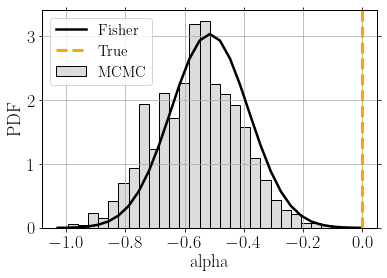

In [8]:
"""
Posteriors with Fisher estimates
"""


_, bins_alpha, _= plt.hist(alpha_samples, 30, histtype = 'bar', color ='gainsboro', density=True, edgecolor='black', label='MCMC')
bins_alpha= np.array(bins_alpha)
Da=np.sqrt(1/gamma_lambda)
plt.plot(bins_alpha, gaussian(bins_alpha,np.median(bins_alpha),Da**2), color='black', lw=2.5,label='Fisher')
    

plt.axvline(x=alpha0_t, label='True', c='orange',ls='--',lw=3)
plt.xlabel('alpha')
plt.ylabel('PDF')
plt.legend()
plt.show()